In [2]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.stats import ttest_ind
import scipy.stats as stats
import scipy.stats as ss
from matplotlib import style
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
import pandas as pd

from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn

plt.style.context("seaborn-whitegrid")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


hiv status, need to run for hiv pos and neg seprately and then plot together

In [3]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'

In [4]:
# tcga cesc snp6 array  copy number segment data
# this is the snp6 copy number pipeline description
tf = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/gdac.broadinstitute.org_CESC.Merge_snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.Level_3.2016012800.0.0/CESC.snp__genome_wide_snp_6__broad_mit_edu__Level_3__segmented_scna_minus_germline_cnv_hg19__seg.seg.txt'
tdf = pd.read_csv(tf, sep='\t')
tdf.head(2)

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean
0,TCGA-2W-A8YY-10A-01D-A37M-01,1,3218610,247813706,129020.0,0.0023
1,TCGA-2W-A8YY-10A-01D-A37M-01,2,484222,197697735,104518.0,0.0041


In [5]:
tdf.Segment_Mean.describe()


count    59450.000000
mean        -0.277859
std          0.909053
min         -7.880800
25%         -0.578700
50%         -0.001300
75%          0.059200
max          6.388700
Name: Segment_Mean, dtype: float64

In [7]:
# tdf[tdf.Segment_Mean == 0.0000]

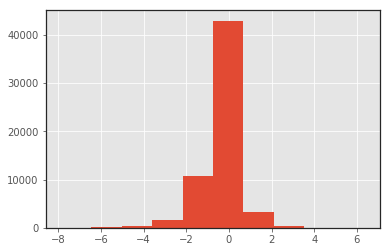

In [8]:
tdf.Segment_Mean.hist()

what is gain and what is loss? it can not be just >0 and <0, there should be a threshold?, Segment_Mean is log2CN-1

In [9]:
tdf.Sample.apply(lambda x: x.split('-')[3]).unique()

array(['10A', '01A', '10B', '01B', '01C', '11A', '06A', '11C'],
      dtype=object)

In [10]:
tdf['tumour_or_normal'] = tdf.Sample.apply(lambda x: x.split('-')[3])

In [11]:
tdf = tdf[~tdf.tumour_or_normal.isin(['10A', '10B', '11A', '11C'])]

In [12]:
tdf.head(2)
tdf.shape

,Sample,Chromosome,Start,End,Num_Probes,Segment_Mean,tumour_or_normal
41,TCGA-2W-A8YY-01A-11D-A37M-01,1,3218610,247813706,128923.0,0.0158,01A
42,TCGA-2W-A8YY-01A-11D-A37M-01,2,484222,150727175,78233.0,0.0076,01A


(41253, 7)

In [37]:
tdf.Sample.apply(lambda x: '-'.join(x.split('-')[:3])).nunique() # only two samples with duplicated biopsies

tdf.Sample.nunique()
# all 178 sample in TCGA core set are in this file except 1: TCGA-EA-A3HU-01A

295

297

In [36]:
pd.Series(tdf.Sample.apply(lambda x: '-'.join(x.split('-')[:4])).unique()).to_csv('/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_variants/cn_patients_297.txt', index=False)

In [16]:
tdf['CN'] = np.power(2, (tdf.Segment_Mean + 1))

In [29]:
tdf.CN.describe()

count    41253.000000
mean         2.029823
std          1.719877
min          0.008485
25%          1.342573
50%          1.977394
75%          2.254176
max        167.579283
Name: CN, dtype: float64

(0, 10)

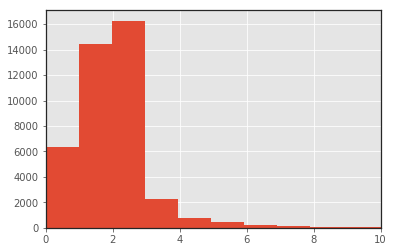

In [28]:
tdf.CN.hist(bins=170)
plt.xlim(0,10)

In [173]:
inf = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
clinic = pd.read_csv(inf, sep='\t', index_col='patient')
clinic.head()

,snv_counts,indel_counts,snv_sns_counts,indel_sns_counts,snv_syno_counts,indel_syno_counts,strelka_mutations,strelka_coding_mutations,strelka_syno_mutations,strelka_nsyno_mutations,...,live_birth_pregnancy_count,menopause_status,nadir_cd4_counts,patient_id,pregnancies_count_induced_abortion,pregnancies_count_miscarriage,tobacco_smoking_history_indicator,total_pregnancy_count,tumor_grade,weight_kg_at_diagnosis
patient,,,,,,,,,,,,,,,,,,,,,
HTMCP-03-06-02001,25732,1242,329,11,102,0,26974,340,102,238,...,5.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2001.0,NaN,1.0,1.0,6.0,G2,44.5
HTMCP-03-06-02002,15964,697,225,2,72,0,16661,227,72,155,...,8.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2002.0,3.0,NaN,1.0,11.0,G3,70.2
HTMCP-03-06-02003,7914,483,89,3,29,0,8397,92,29,63,...,4.0,Pre (<6 months since LMP AND no prior bilatera...,NaN,2003.0,NaN,NaN,1.0,5.0,G2,56.2
HTMCP-03-06-02006,19931,1766,258,16,84,0,21697,274,84,190,...,2.0,Pre (<6 months since LMP AND no prior bilatera...,NaN,2006.0,1.0,NaN,1.0,3.0,G3,61.3
HTMCP-03-06-02007,2928432,29850,20685,50,4469,0,2958282,20735,4469,16266,...,6.0,Post (prior bilateral ovariectomy OR >12 mo si...,NaN,2007.0,NaN,NaN,1.0,6.0,G3,47.1


In [174]:
assert ('HTMCP-03-06-02061' in clinic.index) == False
HIV_pos = clinic.query('HIV_status == "{}"'.format('Positive')).index.tolist()
HIV_neg = clinic.query('HIV_status == "{}"'.format('Negative')).index.tolist()

visualize all cnvs in one plot

In [175]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/Cervical_124_patients_adjusted/cnv_files_for_acen_removal.txt'
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cleaned_cnv_files.txt'
df1 = pd.read_csv(f1, sep='\t', header=None, comment='#')
df1.columns = ['patient', 'seg_path']
assert df1.shape[0] == 124
df1.head(2)

,patient,seg_path
0,HTMCP-03-06-02001,/projects/trans_scratch/validations/workspace/...
1,HTMCP-03-06-02002,/projects/trans_scratch/validations/workspace/...


In [176]:
df1.shape

(124, 2)

In [177]:
df1 = df1.loc[df1.patient.isin(HIV_pos)]
# df1 = df1.loc[df1.patient.isin(HIV_neg)]

In [178]:
df2 = pd.DataFrame()
for idx, row in df1.iterrows():
    pat = row['patient']
    seg_file = row['seg_path']
#     print(pat, seg_file)
    # cnv_files, some rows have 10 columns instead of 9, problems from the APLcnv pipeline
    cnv = pd.read_csv(seg_file, sep='\t',  error_bad_lines=False, warn_bad_lines=True)
    cnv.columns = ['chr', 'start', 'end', 'cn']
    cnv = cnv[cnv.cn != 2]
    cnv['patient'] = pat
    if df2.empty:
        df2 = cnv
    else: df2 = pd.concat([df2,cnv])

In [179]:
df2.tail(2)

,chr,start,end,cn,patient
892,23,80846333,155112387,3,HTMCP-03-06-02447
28,20,14917359,15022654,1,HTMCP-03-06-02448


In [180]:
df2.shape

(26573, 5)

In [181]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned.txt'
df2[df2.cn >2].to_csv(of, index=False, header=None, sep='\t')

In [182]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned.txt'
df2[df2.cn <2].to_csv(of, index=False, header=None, sep='\t')

In [183]:
%%bash
# run this in this dir: 
bedtools=/home/rcorbett/aligners/bedtools/BEDTools-Version-2.15.0/bin/bedtools
cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/
sort -k1n -k2n -k3n amps_cleaned.txt > amps_cleaned.txt.sorted
sort -k1n -k2n -k3n dels_cleaned.txt > dels_cleaned.txt.sorted
$bedtools intersect -a chr_bins.txt -b dels_cleaned.txt.sorted -wa -wb > dels_cleaned_bins_1kb.txt
$bedtools intersect -a chr_bins.txt -b amps_cleaned.txt.sorted -wa -wb > amps_cleaned_bins_1kb.txt

In [61]:
patients = df2.patient.value_counts().index.tolist()

In [184]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_amps = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/amps_cleaned_bins_1kb_patients.txt'
recur_amps.to_csv(f, index=False, sep='\t')
# recur_amps = pd.read_csv(f, sep='\t')

In [63]:
recur_amps.head(2)

,bin_chr,bin_start,bin_end,patient
0,1,38001,39000,1
1,1,39001,40000,2


In [64]:
f11 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/chr_bins.txt'
df11 = pd.read_csv(f11, sep='\t', header=None)
df11.columns = ['bin_chr', 'bin_start', 'bin_end']
df11.set_index(['bin_chr', 'bin_start', 'bin_end'], inplace=True)
# df11['patient'] = 0
df11.head()

Empty DataFrame
Columns: []
Index: [(1, 1, 1000), (1, 1001, 2000), (1, 2001, 3000), (1, 3001, 4000), (1, 4001, 5000)]

In [65]:
def reindex_df(indf):
    df = indf.set_index(['bin_chr', 'bin_start', 'bin_end']).reindex(df11.index)
    df.fillna(0, inplace=True)
    df['fraction_patients'] = df.patient/ len(HIV_pos)
    df.drop('patient', inplace=True, axis=1)
    return df

In [66]:
# df_amps.reset_index()['bin_start'].cumsum() # not just accumulateive sum, depending on chr.

In [67]:
def calculate_fractions(df):
    end = 0
    all_positions = []
    all_fractions = []
    for ch, length in enumerate(chr_length):
        ch+=1
        positions = list(end + np.array(df.iloc[df.index.get_level_values('bin_chr') == ch].index.get_level_values('bin_start').tolist()))
        all_positions = all_positions + positions
        fractions = df.iloc[df.index.get_level_values('bin_chr') == ch]['fraction_patients'].tolist()
        all_fractions = all_fractions + fractions
        end+=length
    return (all_positions, all_fractions)




In [185]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb.txt'
df = pd.read_csv(f, sep='\t', header=None)
df.columns = ['bin_chr', 'bin_start', 'bin_end', 'chr', 'start', 'end', 'cn', 'patient']
occurrence = df.groupby(['bin_chr', 'bin_start', 'bin_end']).nunique()['patient']#.sort_values(ascending=False)
recur_dels = occurrence.reset_index().sort_values(['bin_chr', 'bin_start', 'bin_end'])
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/bin_segs/dels_cleaned_bins_1kb_patients.txt'
recur_dels.to_csv(f, index=False, sep='\t')
# recur_dels = pd.read_csv(f, sep='\t')

In [186]:
recur_dels.head(2)

,bin_chr,bin_start,bin_end,patient
0,1,46001,47000,1
1,1,47001,48000,2


In [70]:
hiv_pos_recur_dels = recur_dels
hiv_pos_recur_amps = recur_amps
# hiv_neg_recur_dels = recur_dels
# hiv_neg_recur_amps = recur_amps

In [24]:
# 2 patient has no cnv? 2261 and 2262 have no cnvs
len(patients)
set(HIV_neg) - set(patients)

set()

In [25]:
f2_1 = '/home/szong/projects/resource/chrominfo.txt'
df2_1 = pd.read_csv(f2_1, sep='\t', usecols=['#chrom', 'size'])
df2_1['chr'] = df2_1['#chrom'].apply(lambda x: x.replace('chr', ''))
chr_sizes = df2_1.set_index('chr').drop('#chrom', axis=1)
chr_sizes = chr_sizes.reset_index().replace('X', '23').replace('Y', '24').iloc[:24,].set_index('chr')
chr_sizes.index = chr_sizes.index.astype(int)
chr_sizes = chr_sizes.sort_index()
chr_sizes.head(2)

,size
chr,
1,249250621
2,243199373


In [26]:
chr_sizes.tail()

,size
chr,
20,63025520
21,48129895
22,51304566
23,155270560
24,59373566


In [27]:
chr_sizes.index.unique()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24],
           dtype='int64', name='chr')

In [43]:
hiv_neg_recur_amps = recur_amps
hiv_neg_recur_dels = recur_dels

In [28]:
# hiv_pos
# for amps
# df_amps = reindex_df(hiv_pos_recur_amps)
# df_amps = reindex_df(hiv_neg_recur_amps)
# amp_positions, amp_fractions = calculate_fractions(df_amps)

NameError: name 'hiv_pos_recur_amps' is not defined

In [30]:
def plot_fraction(coordinates, fractions, baseline, cnv_type, ax):
    baseline_postions = [baseline] * len(coordinates)
    if cnv_type.lower() == 'amps':
        fractions = baseline + np.array(fractions)
        color = 'red'
    elif cnv_type.lower() == 'dels':
        fractions = baseline - np.array(fractions)
        color = 'blue'
    ax.fill_between(coordinates, 
                    fractions, 
                    baseline_postions, 
                    color=color, 
                    alpha=1)

In [31]:
def get_coordinates_fractions(indf):
    df = reindex_df(indf)
    coordinates, fractions = calculate_fractions(df)
    return (coordinates, fractions)

In [32]:

def get_cnv_oncogenes(gistic_f):
    gistic_df = pd.read_csv(gistic_f, sep='\t')
    gistic_df['oncogene'] = gistic_df.oncogenes.apply(lambda x: x.split(')')[1])
    gistic_df['peak_center'] = gistic_df['wide peak boundaries'].apply(lambda x: int(np.array(x.split('-')).astype(int).mean()))
    gistic_df.drop('oncogenes', axis=1, inplace=True)
    gistic_df = gistic_df[gistic_df.oncogene != '']
    return gistic_df

In [34]:
def gene_coordinate(df):
    end = 0
    all_coordinates = []
    all_genes = []
    for ch, length in enumerate(chr_length):
        ch+=1
        coordinates = list(end + np.array(df.loc[df.chr == ch]['peak_center'].tolist()))
        all_coordinates = all_coordinates + coordinates
        genes = df.loc[df.chr == ch]['oncogene'].tolist()
        all_genes = all_genes + genes
        end+=length
    return (all_coordinates, all_genes)

In [35]:
def get_gene_coords(gistic_f):
#     gistic_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
    gistic_df = get_cnv_oncogenes(gistic_f)
    coordinates, genes = gene_coordinate(gistic_df)
    return coordinates, genes

In [146]:
def arrange_genes(genes, coordinates, anno_baseline, 
               anno_color, anno_ecolor, arrow_color, 
               ycoords_dict, df):
#     previous_coordinate = 0
#     y_coords = np.arange(6, .5, -0.5)
#     shorter_genes = []
#     for gene in genes:
#         # only displace 2 genes in a label
#         splits = gene.split(',')
#         if len(splits) >2:
#                gene = ','.join(splits[:2])                
#         shorter_genes.append(gene)
#     genes = shorter_genes
    gene_coords = []
    for gene, x_coord in zip(genes, coordinates):
        short_gene = gene
        splits = gene.split(',')
        if len(splits) >2:
            short_gene = ','.join(splits[:2])  
          
        for y_coord in y_coords:
            if all([abs(j-x_coord) >4e8 for j in ycoords_dict[y_coord]]):
                gene_coords.append((short_gene, x_coord, y_coord, gene))
                coords_list = ycoords_dict[y_coord]
                coords_list.append(x_coord)
                ycoords_dict[y_coord] = coords_list
                break #found location to place the label
    dftmp = pd.DataFrame(gene_coords, columns=['gene', 'x', 'y', 'all_oncogenes'])
    dftmp['anno_color'] = anno_color
    dftmp['anno_ecolor'] = anno_ecolor
    dftmp['arrow_color'] = arrow_color
    df = pd.concat([df, dftmp])
    return (ycoords_dict, df) #coordinates for gene lable

In [162]:
def plot_genes(ax, df):
    df = df.sort_values(['y', 'x'], ascending=True)
    for ix, row in df.iterrows():  
        gene = row.gene
        x = row.x
        y = row.y
        anno_color = row.anno_color
        anno_ecolor = row.anno_ecolor
        arrow_color = row.arrow_color
        fill_color = row.fill_color
        ax.annotate('{}'.format(gene),
                    xy=(x,10), 
                    xytext=(x, y), fontsize=10,
                    ha='center', va='bottom', color=anno_color,
                    textcoords='data', xycoords="data", 
                    bbox=dict(boxstyle='round', 
                              fc=fill_color, 
                              edgecolor=anno_ecolor,
                              alpha=1, pad=.4),
                    arrowprops=dict(arrowstyle='-', 
                                    color=anno_color,
                                    shrinkB=0, 
                                    connectionstyle='arc3,rad=0.0' 
                                  ))


In [147]:
# initiate occupied label coordinates dict
chr_length = chr_sizes['size']#.astype(str)
y_coords = np.arange(7, .5, -0.5)
ycoords_dict = {}
for i in y_coords:
    ycoords_dict[i] = []
    
# initiate label coordinates df
df = pd.DataFrame(columns=['gene', 'x', 'y', 'all_oncogenes', 'anno_color', 'anno_ecolor', 'arrow_color'])
fdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/'

gistic_f = '{}124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# hiv_pos amps
anno_baseline = 6
anno_color = 'red'
anno_ecolor = 'red'
arrow_color = 'red'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)
# print(df)
gistic_f = '{}124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# hiv_pos dels

anno_color = 'blue'
anno_ecolor = 'red'
arrow_color = 'blue'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)
# print(df)

# plot hiv_neg genes
gistic_f = '{}124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# amps

anno_color = 'red'
anno_ecolor = 'blue'
arrow_color = 'red'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)

gistic_f = '{}124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'.format(fdir)
coordinates, genes = get_gene_coords(gistic_f)
# del

anno_color = 'blue'
anno_ecolor = 'blue'
arrow_color = 'blue'
ycoords_dict, df = arrange_genes(genes, coordinates, anno_baseline, 
                                 anno_color, anno_ecolor, arrow_color, 
                                 ycoords_dict, df)

In [148]:
df['fill_color'] = 'lightgray'

In [170]:
# df

In [168]:
f = '{}genes_to_highlight.txt'.format(wkdir)
# df.to_csv(f, sep='\t', index=False)
df = pd.read_csv(f, sep='\t')
df.head(2)

,gene,x,y,all_oncogenes,anno_color,anno_ecolor,arrow_color,fill_color
0,(79)AKT1,2304079939,1.5,"AKT1,BRF1,MIR203",blue,blue,blue,lightgray
1,"(115)RB1,TLL",2127705678,2.0,"ARL11,DLEU1,MIR15A,RB1,TTL,DLEU2,KCNRG,LHFP,MI...",blue,blue,blue,lightgray


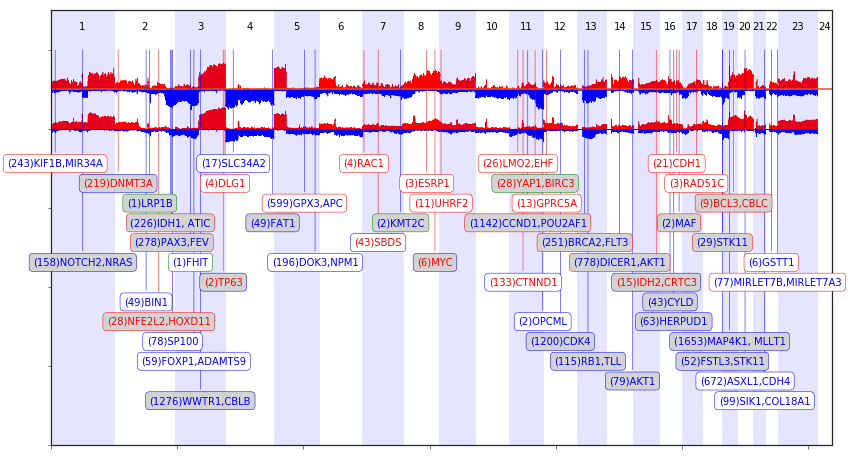

In [171]:

fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, facecolor='white')

# plot baseline
start = 0
end = 0
baseline = 9
for ch, length in enumerate(chr_length):
    ch+=1
    end+=length
    midpoint = (start + end)/2
    ax.text(midpoint, 10.5, ch, ha='center')
    if ch %2 == 1:
        fill([start, end, end, start], [0, 0, 11, 11], 'b', alpha=0.1, edgecolor='b')
    start+=length
axhline(baseline)

# area plot example fill between 2 lines
# hiv_pos
baseline = 9
coordinates, fractions = get_coordinates_fractions(hiv_pos_recur_amps)
plot_fraction(coordinates, fractions, baseline, 'amps', ax)
coordinates, fractions = get_coordinates_fractions(hiv_pos_recur_dels)
plot_fraction(coordinates, fractions, baseline, 'dels', ax)

#plot hiv_neg
baseline = 8
coordinates, fractions = get_coordinates_fractions(hiv_neg_recur_amps)
plot_fraction(coordinates, fractions, baseline, 'amps', ax)
coordinates, fractions = get_coordinates_fractions(hiv_neg_recur_dels)
plot_fraction(coordinates, fractions, baseline, 'dels', ax)






# plot all annoatations
plot_genes(ax, df)
ax.set_xlim(0,sum(chr_length))
ax.set_ylim(0,11)
ax.set_xticklabels('')
ax.set_yticklabels('')
# plt.savefig('{}cnvs_publication.png'.format(wkdir), dpi=300, bbox_inches='tight')
plt.show()

# look at expression at chromosome 20

In [192]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/hotspots/123_patients/12_hiv_pos_patient_with_CELF2_intronic_mutaions.txt'
df44 = pd.read_csv(f, sep=' ', header=None, usecols=[6])
CELF2_patients = df44[6].tolist()

In [241]:
f2 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/expression.txt'
df45 = pd.read_csv(f2, sep='\t')
df45['genes'] = df45.genes.apply(lambda x: x.split('_')[1])
df45.set_index('genes',inplace=True)
df45

,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
genes,,,,,,,,,,,,,,,,,,,,,
BMP2,24.2485,0.5206,22.7987,16.7144,3.3167,0.9090,5.6723,0.2779,11.9332,11.7344,...,2.4231,15.9290,7.3584,7.5151,22.5350,7.6255,1.6486,15.3510,6.6484,23.3014
NRSN2,8.7759,12.1225,13.0852,15.2838,26.1307,10.5814,13.6064,18.5685,15.1423,17.0035,...,10.6567,11.1115,19.5867,15.0157,11.1103,4.5144,37.4468,38.9413,15.7422,18.2746
RASSF2,0.9829,1.6913,2.6299,2.2896,3.8333,5.3300,1.7596,2.4763,2.8904,3.5951,...,0.6380,0.2974,1.8222,1.7395,0.6566,1.7666,4.7340,2.5992,3.4487,4.7909
CELF2,1.0604,2.0148,1.7215,1.1998,4.8031,3.5291,1.4222,1.5524,2.1163,1.6890,...,0.7011,0.1661,2.6070,0.7677,0.3114,1.4427,17.3580,1.2862,1.3097,2.2684
LEF1,2.3424,3.3140,1.1988,2.3581,24.0241,4.7774,1.8252,1.3020,2.9927,0.6506,...,0.4918,0.2495,3.0928,1.2006,0.3725,1.0076,4.0649,1.1239,1.6038,1.9845
POTEG,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0007,0.0000,0.0000,...,0.0000,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AQP7,0.0089,0.0068,0.0684,0.0527,0.0166,0.1316,0.0066,0.0133,0.0141,0.6473,...,0.0663,2.7351,0.5844,0.0248,0.0862,0.7812,1.4339,0.0810,0.0551,0.5056


In [245]:
f3 = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/BMP2.txt'
bmp2_cnv = pd.read_csv(f3, sep='\t', header=None, usecols=[0,6])
bmp2_cnv.columns = ['pat', 'cnv']
bmp2_cnv.head(2)

,pat,cnv
0,HTMCP-03-06-02001,2
1,HTMCP-03-06-02002,2


In [247]:
df_bmps = pd.DataFrame(df45.loc["BMP2",]).reset_index()

In [251]:
df47 = pd.merge(bmp2_cnv, df_bmps, left_on='pat', right_on='index')[['pat', 'cnv', 'BMP2']]

In [232]:
df46 = pd.DataFrame(df45.loc["LEF1",]).reset_index()

In [233]:
df46.head(2)

,index,LEF1
0,HTMCP-03-06-02001,2.3424
1,HTMCP-03-06-02002,3.3140


In [234]:
df46['celf2'] = df46['index'].apply(lambda x: 'mut' if x in CELF2_patients else 'wt')

In [235]:
df46.head(2)

,index,LEF1,celf2
0,HTMCP-03-06-02001,2.3424,wt
1,HTMCP-03-06-02002,3.3140,wt


In [198]:
CELF2_muts = df45[CELF2_patients]
CELF2_muts

,HTMCP-03-06-02239,HTMCP-03-06-02216,HTMCP-03-06-02437,HTMCP-03-06-02144,HTMCP-03-06-02202,HTMCP-03-06-02414,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02103,HTMCP-03-06-02103,HTMCP-03-06-02447,HTMCP-03-06-02238,HTMCP-03-06-02071,HTMCP-03-06-02071,HTMCP-03-06-02071,HTMCP-03-06-02071
genes,,,,,,,,,,,,,,,,
BMP2,9.8771,10.7918,7.6255,0.3128,12.6240,15.9600,1.6486,15.3510,21.4400,21.4400,6.6484,7.7629,13.6245,13.6245,13.6245,13.6245
NRSN2,9.0386,14.5508,4.5144,17.5379,19.2714,30.5230,37.4468,38.9413,25.6907,25.6907,15.7422,8.6737,11.6981,11.6981,11.6981,11.6981
RASSF2,0.8492,0.5651,1.7666,4.0812,7.3412,1.6530,4.7340,2.5992,2.8545,2.8545,3.4487,3.4134,2.8528,2.8528,2.8528,2.8528
CELF2,1.3896,0.2450,1.4427,1.6190,3.1406,3.1747,17.3580,1.2862,1.0741,1.0741,1.3097,2.2163,1.0169,1.0169,1.0169,1.0169
LEF1,0.9201,0.7904,1.0076,2.6970,1.6692,12.9375,4.0649,1.1239,1.2212,1.2212,1.6038,1.6132,1.3526,1.3526,1.3526,1.3526
POTEG,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
AQP7,0.0038,0.0450,0.7812,0.0041,0.0576,0.2743,1.4339,0.0810,0.0196,0.0196,0.0551,0.6525,0.0000,0.0000,0.0000,0.0000


In [203]:
CELF2_wt = df45[[i for i in df45.columns.tolist() if i not in  CELF2_patients]]

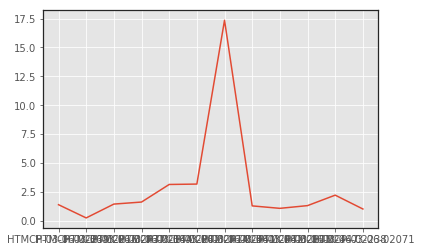

In [204]:
plt.plot(CELF2_muts.loc["CELF2",])

In [215]:
muts = CELF2_muts.loc["CELF2",].values
wts = CELF2_wt.loc["CELF2",].values

In [211]:
muts

array([ 1.3896,  0.245 ,  1.4427,  1.619 ,  3.1406,  3.1747, 17.358 ,
        1.2862,  1.0741,  1.0741,  1.3097,  2.2163,  1.0169,  1.0169,
        1.0169,  1.0169])

In [230]:
df46.head()

,index,CELF2,celf2
0,HTMCP-03-06-02001,1.0604,wt
1,HTMCP-03-06-02002,2.0148,wt
2,HTMCP-03-06-02003,1.7215,wt
3,HTMCP-03-06-02006,1.1998,wt
4,HTMCP-03-06-02007,4.8031,wt


In [252]:
df47.head()

,pat,cnv,BMP2
0,HTMCP-03-06-02001,2,24.2485
1,HTMCP-03-06-02002,2,0.5206
2,HTMCP-03-06-02003,3,22.7987
3,HTMCP-03-06-02006,2,16.7144
4,HTMCP-03-06-02007,2,3.3167


0.08874342839133187


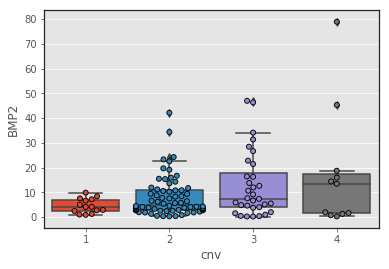

In [263]:
fig = plt.figure()
ax = fig.add_subplot(111)
group_col = 'cnv'
value_col = 'BMP2'
sns.swarmplot(x=group_col, y=value_col, data=df47, edgecolor="black", linewidth=.9, facecolor='blue')
sns.boxplot(x=group_col, y=value_col, data=df47, saturation=1, ax=ax)
g1 = df47.query('{0}=="{1}"'.format(group_col, 1))[value_col]
g2 = df47.query('{0}=="{1}"'.format(group_col, 2))[value_col]
sts, p = ss.mannwhitneyu(g1, g2, use_continuity=True, alternative=None)
print(p)
# sns.swarmplot([2]*len(wts), wts, edgecolor="black", linewidth=.9, facecolor="red")

In [262]:
df47.query('{0}=="{1}"'.format(group_col, 1))

,pat,cnv,BMP2
5,HTMCP-03-06-02008,1,0.9090
16,HTMCP-03-06-02054,1,4.1518
26,HTMCP-03-06-02076,1,2.9091
35,HTMCP-03-06-02139,1,1.0261
43,HTMCP-03-06-02147,1,4.0946
61,HTMCP-03-06-02151,1,2.4556
66,HTMCP-03-06-02213,1,2.7366
71,HTMCP-03-06-02204,1,7.5640
76,HTMCP-03-06-02235,1,1.2797
78,HTMCP-03-06-02239,1,9.8771


In [13]:
np.argmax?